In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import ipywidgets as widgets
from PIL import Image

im_wfence = Image.open("./NS_data/E7.3_80x80_py_40M_recall.k3.r.40000000.nnd-ref.png")

initiating GUI


ColorPicker(value='#0000FF', description='Pick a color:')

Button(description='Save Image', style=ButtonStyle())

Button(description='Change Mode: False', style=ButtonStyle())

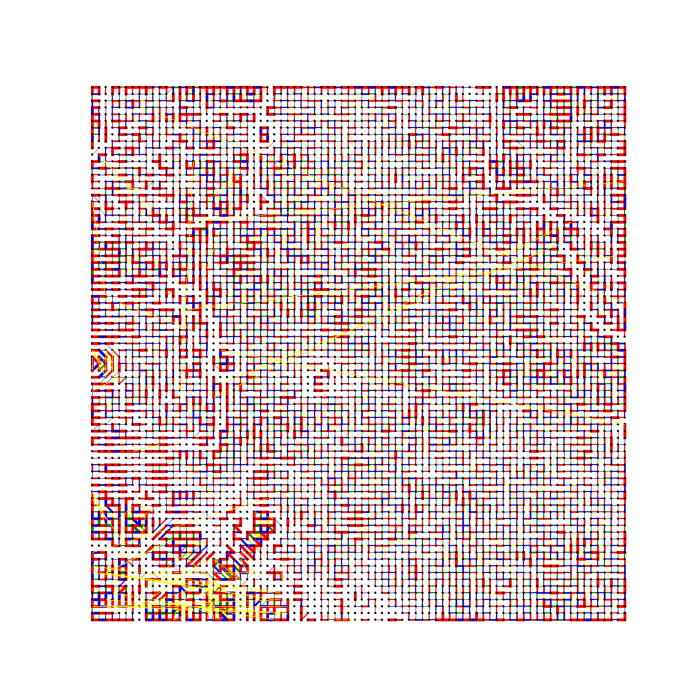

In [61]:
editor = BlockImageEditor(im_wfence, './NS_data/E7.3_80x80_py_40M_recall.remap1.png')

In [83]:
plt.close('all')

In [3]:
class BlockImageEditor:
    """
    Needs to be updated!
    A block-based image editor which allows interactive modifications of an image.
    
    How to use:
    -----------
    right click: change color of current block to selected color.
    left click:  Copy the color of an existing block.
    middle button click: Returns block to its original color

    Attributes:
    -----------
    fence : bool
        If True, a 2-pixel thick fence will be drawn around each block. Use when the original image has a fence.
    output_name : str
        The filename where the edited image will be saved.
    img_array : ndarray
        A numpy array representation of the input image.
    block_size : int, optional, default=12
        The size (both width and height) of each block in the image.
    color_picker : ColorPicker
        A widget for picking colors interactively.
    image : ndarray
        A numpy array representing the current state of the edited image.
    initial_image : ndarray
        A numpy array storing the original state of the image for undo operations.
    fig, ax : Figure, Axes
        Matplotlib's figure and axes objects for displaying the image.
    rgb : tuple
        The current color selected in the color picker, represented in RGB format.
    save_button : Button
        A widget button to save the current state of the edited image.

    Methods:
    --------
    onclick(event) -> None
        Handles mouse click events for the image display.
    update_block_color(row, col, color) -> None
        Updates the color of a specific block in the image.
    hex_to_rgb(value) -> tuple
        Converts a HEX color code to an RGB tuple.
    on_color_change(change) -> None
        Handles changes in the color picker widget and updates the `rgb` attribute.
    save_image(change) -> None
        Saves the current image to a specified filename without surrounding whitespace.

    Parameters:
    -----------
    image : ndarray or Image object
        The input image to be edited.
    output_name : str
        The filename where the edited image will be saved.
    block_size : int, optional, default=12
        The size (both width and height) of each block in the image.
    fence : bool, optional, default=False
        If True, a 2-pixel thick fence will be drawn around each block.
    """
        
    def __init__(self, image, output_name, block_size=12, fence=False):
        # Modify later to take in images
        print("initiating GUI")
        file_to_delete = open("debug_log.txt",'w')
        file_to_delete.close()
        self.fence = fence
        self.output_name = output_name
        self.img_array = np.array(image)
        _,_,z = np.shape(self.img_array)
        if z == 3:
            pass
        elif z == 4:
            self.img_array = self.img_array[:,:,:3]
        else:
            print("Your image has a wierd number of values in the z dimension")
        [xdim, ydim, zdim] = np.shape(self.img_array)
        #assert xdim == ydim, "Error: not a square SOM"
        blocks_shape = (xdim // block_size, 
                        ydim // block_size)
        self.block_size = block_size
        self.draw_mode = False  # Mode to detect if user is drawing
        self.current_path = []  # Store current drawing path
        self._drawing = False
        self._x = []
        self._y = []
        
        self.color_picker = widgets.ColorPicker(value='#0000FF',
                                                description='Pick a color:')
        
        self.color_picker.observe(self.on_color_change, names='value')
        
        display(self.color_picker)
        
        self.image = self.img_array
        self.initial_image = np.array(image)
        
        self.fig, self.ax = plt.subplots(figsize=(7, 7))
        self.ax.imshow(self.image)
        self.ax.axis('off')
        self.ax.set_xlim(0, self.image.shape[1])
        self.ax.set_ylim(self.image.shape[0], 0)
        self.fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=1, hspace=1)
        
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        
        #self._cid_press = self.fig.canvas.mpl_connect('button_press_event', self._on_press)
        #self._cid_move = self.fig.canvas.mpl_connect('motion_notify_event', self._on_move)
        #self._cid_release = self.fig.canvas.mpl_connect('button_release_event', self._on_release)

        self.rgb = self.hex_to_rgb(self.color_picker.value)
        
        self.save_button = widgets.Button(description="Save Image")
        self.save_button.on_click(self.save_image)
        display(self.save_button)
        
        self.toggle_mode_button = widgets.Button(description="Toggle Drawing Mode")
        self.toggle_mode_button.on_click(self.toggle_mode)
        display(self.toggle_mode_button)
        
        self.complete_drawing_button = widgets.Button(description="Complete Drawing")
        self.complete_drawing_button.on_click(self.complete_drawing)
        display(self.complete_drawing_button)
        
    def onclick(self, event):
        row, col = int(event.ydata // self.block_size), int(event.xdata // self.block_size)
        # Still need to fix draw mode
        if self.draw_mode:
            # should be the ability to draw


            self.current_path.append((event.xdata, event.ydata))
            if len(self.current_path) > 1:
                self.ax.plot(*zip(*self.current_path[-2:]), color='black')
                self.fig.canvas.draw()
            '''   
            if event.button == 1:
                with open("debug_log.txt", "a") as log_file:
                    log_file.write("Detected a double-click!\n")
                self.current_path.append((event.xdata, event.ydata))
                if len(self.current_path) > 1:
                    self.ax.plot(*zip(*self.current_path[-2:]), color='black')
                    self.fig.canvas.draw()
                return
            
            # Should colour the inner region
            if event.button == 3:
                # Handle drawing behavior
                self.fill_enclosed_region()
                self.current_path = []
                return
            '''
        
        if not self.draw_mode:
            if event.button == 1:

                self.update_block_color(row, col, self.rgb)
                #self.update_block_color(row, col, new_color)

            if event.button ==2:
                # remember original image and undo this way
                clicked_box = self.initial_image[(self.block_size//2)+row*self.block_size,
                                                 (self.block_size//2)+col*self.block_size]
                self.update_block_color(row, col, clicked_box)

            if event.button == 3:
                clicked_color = self.image[(self.block_size//2)+row*self.block_size,
                                           (self.block_size//2)+col*self.block_size]
                # Convert RGB to HEX and update the color picker
                hex_value = '#{:02x}{:02x}{:02x}'.format(clicked_color[0], clicked_color[1], clicked_color[2])
                self.color_picker.value = hex_value
                return  
        
    def update_block_color(self, row, col, color, redraw=True):
        if self.fence:
            start_row, end_row = row*self.block_size+2, (row+1)*self.block_size
            start_col, end_col = col*self.block_size, (col+1)*self.block_size-2
        if not self.fence:
            start_row, end_row = row*self.block_size, (row+1)*self.block_size
            start_col, end_col = col*self.block_size, (col+1)*self.block_size
        self.image[start_row:end_row, start_col:end_col] = color
        if redraw:
            self.ax.imshow(self.image)
            self.fig.canvas.draw()
        
    def hex_to_rgb(self, value):
        # Remove the initial hash
        value = value.lstrip('#')
        # Convert to RGB
        return tuple(int(value[i:i+2], 16) for i in (0, 2, 4))

    def on_color_change(self, change):
        #print(change['new'])
        self.rgb = self.hex_to_rgb(change['new'])
        self.current_path = []
        
    def fill_enclosed_region(self):
        if not self.current_path:
            return

        path = Path(self.current_path)
        if self.current_path[0] != self.current_path[-1]:
            self.current_path.append(self.current_path[0])
        #path = Path(self.current_path)
        for i in range(self.image.shape[0] // self.block_size):
            for j in range(self.image.shape[1] // self.block_size):
                block_center = (j*self.block_size + self.block_size/2, i*self.block_size + self.block_size/2)
                with open("debug_log.txt", "a") as log_file:
                    log_file.write(f"Checking block_center: {block_center}\n")
                if path.contains_point(block_center):
                    with open("debug_log.txt", "a") as log_file:
                        log_file.write(f"Coloring block at: {block_center}\n")
                    self.update_block_color(i, j, self.rgb, redraw=False)

        # Clear the current_path
        self.current_path = []
        #self.fig.canvas.draw()
        
        # Remove the lines drawn by the user
        while len(self.ax.lines) > 0:
            self.ax.lines[-1].remove()
        self.ax.imshow(self.image)
        self.fig.canvas.draw()
        
    def _on_press(self, event):
        if event.button == 1:  # Left mouse button.
            self._drawing = True
            self._x = [event.xdata]
            self._y = [event.ydata]
        
    def _on_move(self, event):
        if self._drawing:
            self._x.append(event.xdata)
            self._y.append(event.ydata)
            self.ax.plot(self._x[-2:], self._y[-2:], color=self.rgb)
            self.fig.canvas.draw()
        
    def _on_release(self, event):
        if self._drawing:
            self._drawing = False

            # Close the loop visually by connecting last and first point
            self.ax.plot([self._x[-1], self._x[0]], [self._y[-1], self._y[0]], color=self.rgb)

            # Create the path object
            path = Path(np.column_stack([self._x, self._y]))

            # Fill the freehand shape with the color
            patch = PathPatch(path, facecolor=self.rgb, edgecolor='none')
            self.ax.add_patch(patch)

            # Fill blocks inside the freehand shape with the chosen color
            for (j, i), _ in np.ndenumerate(self.img_array[:-1: self.block_size, :-1: self.block_size]):
                block_center = ((i + self.block_size / 2), (j + self.block_size / 2))
                if path.contains_point(block_center):
                    self.update_block_color(j, i // self.block_size, self.rgb)

            self.fig.canvas.draw()
        
    def save_image(self, change):
        file_name = self.output_name  # Choose a filename or get it from user input
        plt.imsave(file_name, self.image.astype(np.uint8))
        print(f"Image saved as {file_name}")
        
    def change_mode(self, change):
        self.draw_mode = not self.draw_mode
        
    def toggle_mode(self, change):
        self.draw_mode = not self.draw_mode
        if self.draw_mode:
            self.toggle_mode_button.description = "Switch to Editing Mode"
        else:
            self.toggle_mode_button.description = "Toggle Drawing Mode"
            
    def complete_drawing(self, change):
        if self.draw_mode and self.current_path:
            self.fill_enclosed_region()

In [7]:
plt.close('all')

initiating GUI


ColorPicker(value='#0000FF', description='Pick a color:')

Button(description='Save Image', style=ButtonStyle())

Button(description='Toggle Drawing Mode', style=ButtonStyle())

Button(description='Complete Drawing', style=ButtonStyle())

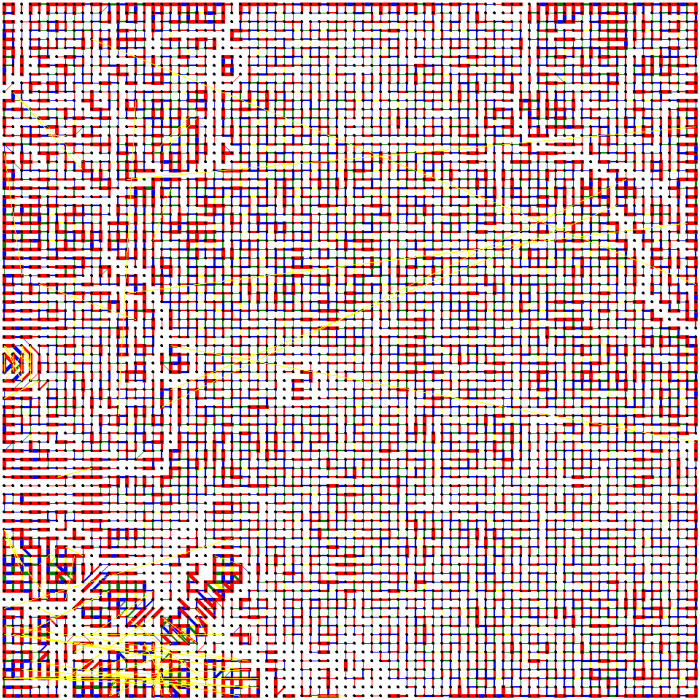

In [12]:
editor2 = BlockImageEditor(im_wfence, './NS_data/E7.3_80x80_py_40M_recall.remap2.png')

In [4]:
im_remaped = Image.open('./NS_data/E7.3_80x80_py_40M_recall.remap3.png')

initiating GUI


ColorPicker(value='#0000FF', description='Pick a color:')

Button(description='Save Image', style=ButtonStyle())

Button(description='Toggle Drawing Mode', style=ButtonStyle())

Button(description='Complete Drawing', style=ButtonStyle())

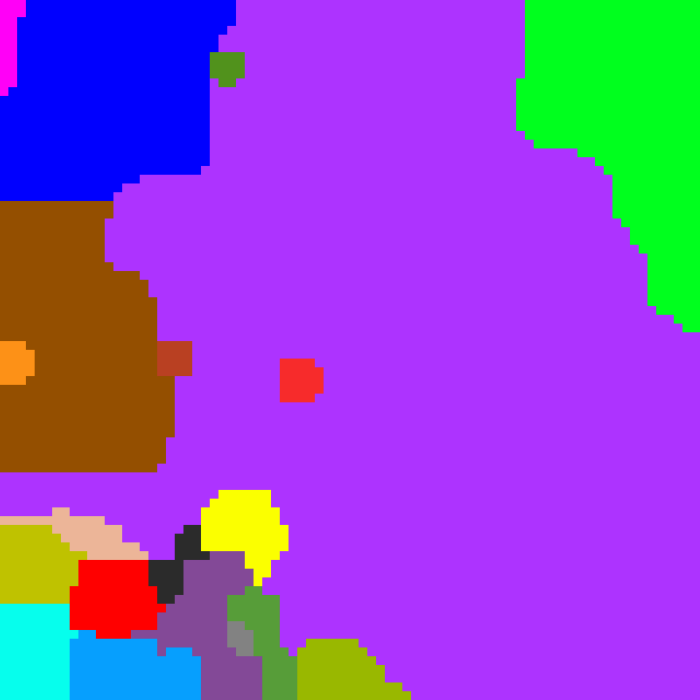

In [5]:
editor3 = BlockImageEditor(im_remaped, './NS_data/E7.3_80x80_py_40M_recall.remap4.png')

In [7]:
im_wfence = Image.open("./NS_data/E7.3_80x80_py_40M_recall.k3.r.40000000.nnd-ref.png")

In [4]:
im_remaped = Image.open('./NS_data/E7.3_80x80_py_40M_recall.remap7.png')

initiating GUI


ColorPicker(value='#0000FF', description='Pick a color:')

Button(description='Save Image', style=ButtonStyle())

Button(description='Toggle Drawing Mode', style=ButtonStyle())

Button(description='Complete Drawing', style=ButtonStyle())

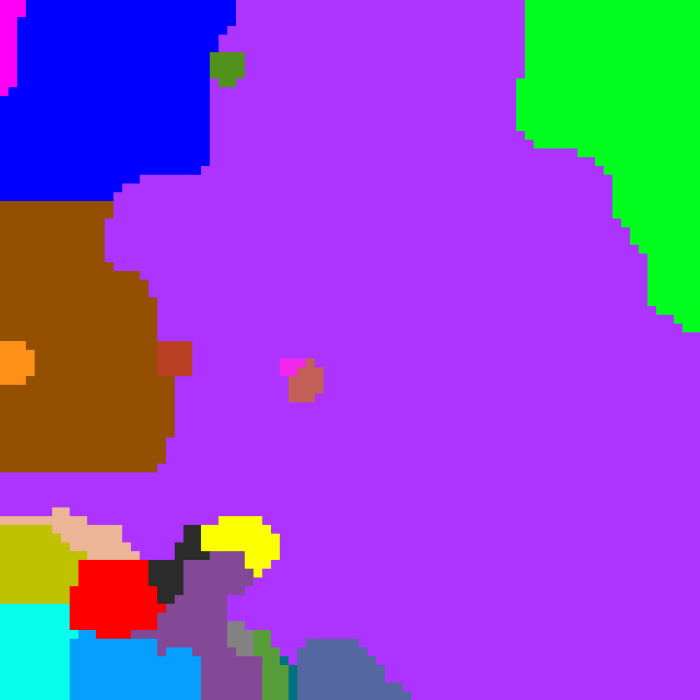

In [5]:
editor4 = BlockImageEditor(im_remaped, './NS_data/E7.3_80x80_py_40M_recall.remap8.png')